<a href="https://colab.research.google.com/github/AthiraSathyan/prediction/blob/main/Dementia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras import Model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input 
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D,InputLayer

In [2]:
IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [3]:
dataGenerator = IDG(preprocessing_function=preprocess_input,
                fill_mode='constant',
                rotation_range=15,
                zoom_range= [.99, 1.01],
                brightness_range= [0.8, 1.2],
                data_format='channels_last',
                horizontal_flip= True)

In [5]:
generator = dataGenerator.flow_from_directory(
    '/content/drive/My Drive/Alzheimer_s Dataset/train_test',
    target_size=DIM,
    batch_size=6400,
    shuffle=False,
    subset='training')

Found 6400 images belonging to 4 classes.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
generator1 = dataGenerator.flow_from_directory(
    '/content/drive/MyDrive/Alzheimer_s Dataset/validation',
    target_size=DIM,
    batch_size=1279,
    shuffle=False,)

Found 1279 images belonging to 4 classes.


In [7]:
print(generator.class_indices)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [9]:
train_data, train_labels = generator.next()

In [10]:
test_data, test_labels =  generator1.next()

In [11]:
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [30]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [31]:
print(train_data.shape)
print(test_data.shape)

(3276, 176, 176, 3)
(1024, 176, 176, 3)


In [32]:
vgg_model = VGG16(input_shape=(176, 176, 3), include_top=False, weights="imagenet")
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 176, 176, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 176, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 176, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 88, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 88, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 88, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 44, 128)       0     

In [33]:
for layer in vgg_model.layers:
    layer.trainable=False

In [34]:
custom_vgg_model = Sequential([
        vgg_model,
        Dropout(0.5),
        Flatten(),
        BatchNormalization(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(4, activation='softmax')        
    ], name = "vgg_cnn_model")
#model.get_config()

In [35]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [36]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback, rop_callback]
    
custom_vgg_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_vgg_model.summary()

Model: "vgg_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 dropout_8 (Dropout)         (None, 5, 5, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 12800)             0         
                                                                 
 batch_normalization_8 (Batc  (None, 12800)            51200     
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 1024)              13108224  
                                                                 
 batch_normalization_9 (Batc  (None, 1024)             4096      
 hNormalization)                                     

In [37]:
history = custom_vgg_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=60)

Epoch 1/60
103/103 [==============================] - 19s 164ms/step - loss: 2.0558 - acc: 0.4350 - auc: 0.6741 - val_loss: 2.6645 - val_acc: 0.4976 - val_auc: 0.6962 - lr: 0.0010
Epoch 2/60
103/103 [==============================] - 14s 136ms/step - loss: 1.3302 - acc: 0.5327 - auc: 0.7928 - val_loss: 1.6502 - val_acc: 0.5829 - val_auc: 0.8064 - lr: 0.0010
Epoch 3/60
103/103 [==============================] - 14s 135ms/step - loss: 1.1033 - acc: 0.5824 - auc: 0.8301 - val_loss: 1.5046 - val_acc: 0.5610 - val_auc: 0.8194 - lr: 0.0010
Epoch 4/60
103/103 [==============================] - 14s 132ms/step - loss: 0.9207 - acc: 0.6322 - auc: 0.8687 - val_loss: 1.3022 - val_acc: 0.6024 - val_auc: 0.8344 - lr: 0.0010
Epoch 5/60
103/103 [==============================] - 14s 132ms/step - loss: 0.8166 - acc: 0.6703 - auc: 0.8920 - val_loss: 1.0605 - val_acc: 0.6085 - val_auc: 0.8526 - lr: 0.0010
Epoch 6/60
103/103 [==============================] - 13s 131ms/step - loss: 0.7479 - acc: 0.6938 - 

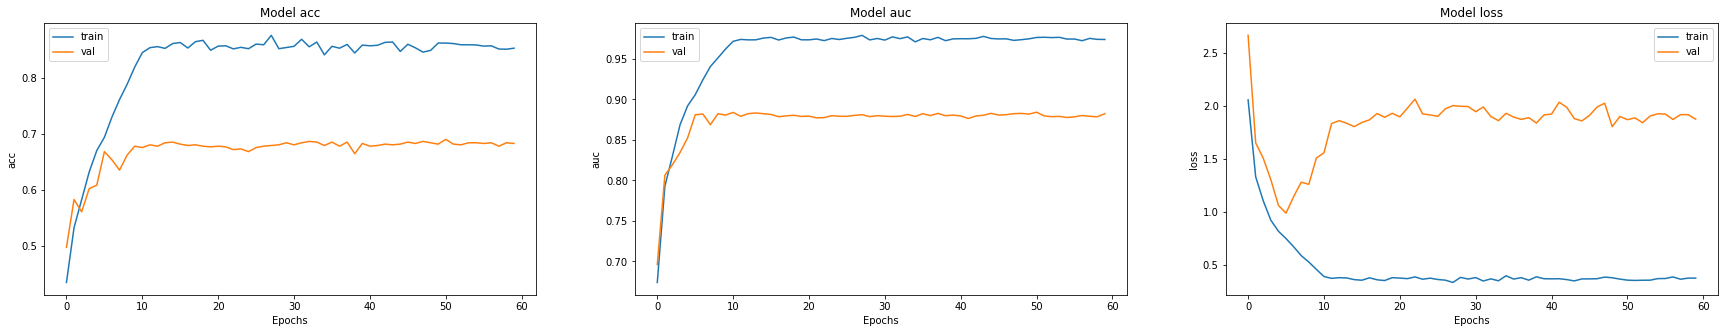

In [38]:
fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [39]:
test_scores = custom_vgg_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

32/32 [==============================] - 4s 101ms/step - loss: 1.6559 - acc: 0.7070 - auc: 0.8933
Testing Accuracy: 70.70%
